In [1]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from dateutil.parser import parse as parse_date

In [2]:
with open(os.path.join(os.pardir, "data", "merged.json")) as fp:
    tweets = json.load(fp)
    for tweet in tweets:
        tweet['created_at'] = parse_date(tweet['created_at'])

# Missing retweets

In [13]:
rows = []

for tweet in tweets:
    if tweet.get('retweet_count', 0) < 100:
        continue
        
    row = {'tweet_id': tweet['id'],
           'created_at': tweet['created_at'],
           'n_retweets': tweet.get('retweet_count', 0),
           'missing_retweets': 100 - len(tweet['retweet_ids'])}
    
    rows.append(row)

In [16]:
df = pd.DataFrame(rows)
df['created_at'] = pd.to_datetime(df['created_at'])
df.head()

,created_at,missing_retweets,n_retweets,tweet_id
0,2016-12-13 00:27:29+00:00,10,627,808468346605883394
1,2016-12-12 23:48:33+00:00,6,2972,808458549844201472
2,2016-12-12 23:24:43+00:00,4,740,808452552677330948
3,2016-12-12 23:21:57+00:00,10,835,808451854430511104
4,2016-12-12 23:02:22+00:00,100,317,808446928572841984


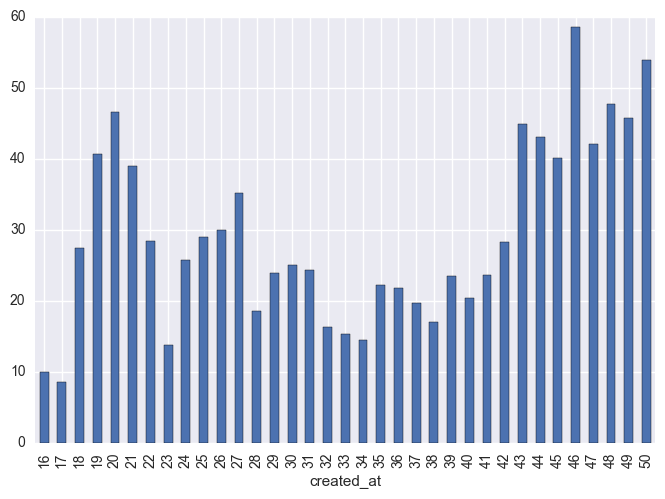

In [21]:
df.groupby(df.created_at.dt.weekofyear)['missing_retweets'].mean().plot(kind='bar');

# Retweeter Competency

In [24]:
from collections import defaultdict

In [26]:
tweet['retweeter_infos'][0]

{'contributors_enabled': False,
 'created_at': 'Sun Mar 20 22:25:56 +0000 2016',
 'default_profile': False,
 'default_profile_image': False,
 'description': 'Security news unfiltered',
 'entities': {'description': {'urls': []},
  'url': {'urls': [{'display_url': 'secnews.io',
     'expanded_url': 'http://secnews.io',
     'indices': [0, 23],
     'url': 'https://t.co/WM6t7E1zMx'}]}},
 'favourites_count': 175,
 'follow_request_sent': False,
 'followers_count': 218,
 'following': False,
 'friends_count': 84,
 'geo_enabled': False,
 'has_extended_profile': False,
 'id': 711680198622621696,
 'id_str': '711680198622621696',
 'is_translation_enabled': False,
 'is_translator': False,
 'lang': 'en',
 'listed_count': 353,
 'location': '',
 'name': 'secnews.io',
 'notifications': False,
 'profile_background_color': '000000',
 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.pn

In [133]:
from time import time

rows = []
now = time()
for tweet in tweets:
    for retweeter in tweet['retweeter_infos']:
        d = {'created_at': tweet['created_at'],
             'n_followers': retweeter['followers_count'],
             'n_friends': retweeter['friends_count'],
             'age': ((now - parse_date(retweeter['created_at']).timestamp()) / 
                     SEC_PER_YEAR),
             'n_favorites': retweeter['favourites_count']}
        
        rows.append(d)
        
df = pd.DataFrame(rows)
df['created_at'] = pd.to_datetime(df['created_at'])
df['followers_to_friends'] = np.where(df['n_friends'] == 0, np.NaN,
                                   (df['n_followers'] / df['n_friends']))
df['faves_per_friends'] = np.where(df['n_friends'] == 0, np.NaN,
                                   (df['n_favorites'] / df['n_friends']))
df['faves_per_follower'] = np.where(df['n_followers'] == 0, np.NaN,
                                   (df['n_favorites'] / df['n_followers']))
df['no_followers'] = df['n_followers'] == 0
df['few_followers'] = df['n_followers'] < 100
df['green_account'] = df['age'] < 0.6
df.head()

,age,created_at,n_favorites,n_followers,n_friends,followers_to_friends,faves_per_friends,faves_per_follower,no_followers,few_followers,green_account
0,0.154407,2016-12-13 00:27:29+00:00,911,61,157,0.388535,5.802548,14.934426,False,True,True
1,0.646095,2016-12-13 00:27:29+00:00,888,243,245,0.991837,3.624490,3.654321,False,False,False
2,0.782233,2016-12-13 00:27:29+00:00,7015,292,356,0.820225,19.705056,24.023973,False,False,False
3,0.516984,2016-12-13 00:27:29+00:00,2104,74,189,0.391534,11.132275,28.432432,False,True,True
4,6.640787,2016-12-13 00:27:29+00:00,11189,344,605,0.568595,18.494215,32.526163,False,False,False


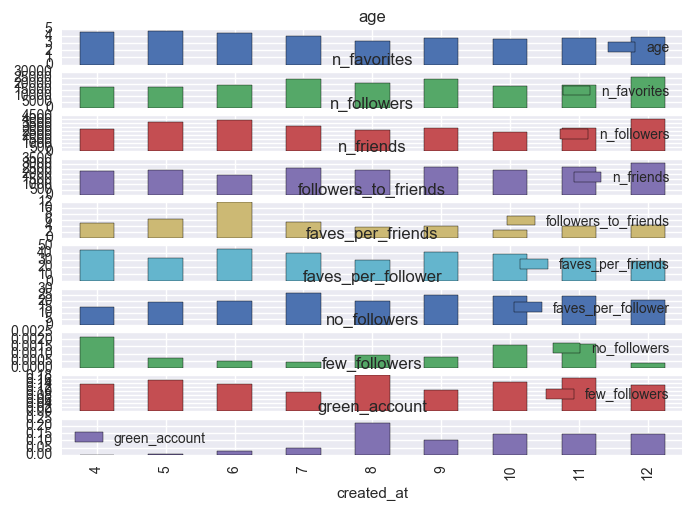

In [134]:
summary_df = df.groupby(df.created_at.dt.month).mean()
summary_df.plot(kind='bar', subplots=True);

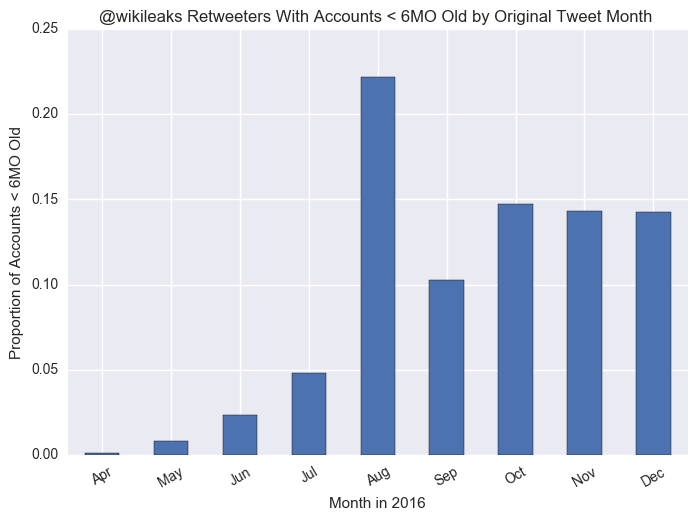

In [144]:
summary_df['green_account'].plot(kind='bar')
plt.title('@wikileaks Retweeters With Accounts < 6MO Old by Original Tweet Month ')
plt.ylabel('Proportion of Accounts < 6MO Old')
plt.xlabel('Month in 2016')
plt.axes().set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug',
                    'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(rotation=30);

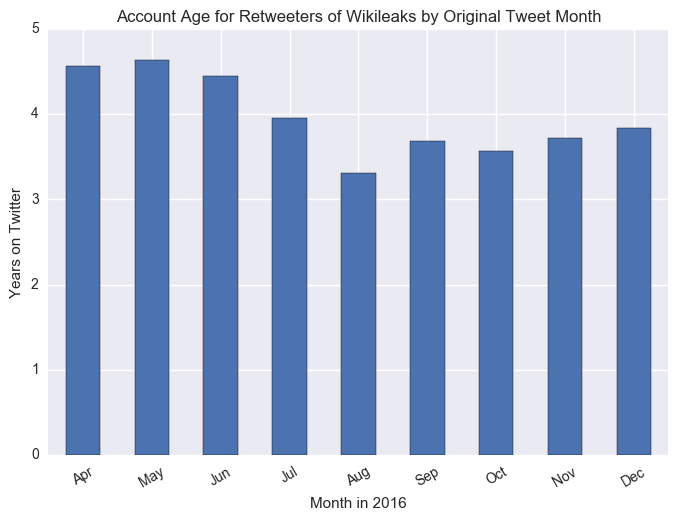

In [141]:
summary_df['age'].plot(kind='bar')
plt.title('Account Age for Retweeters of Wikileaks by Original Tweet Month')
plt.ylabel('Years on Twitter')
plt.xlabel('Month in 2016')
plt.axes().set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug',
                    'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(rotation=30);

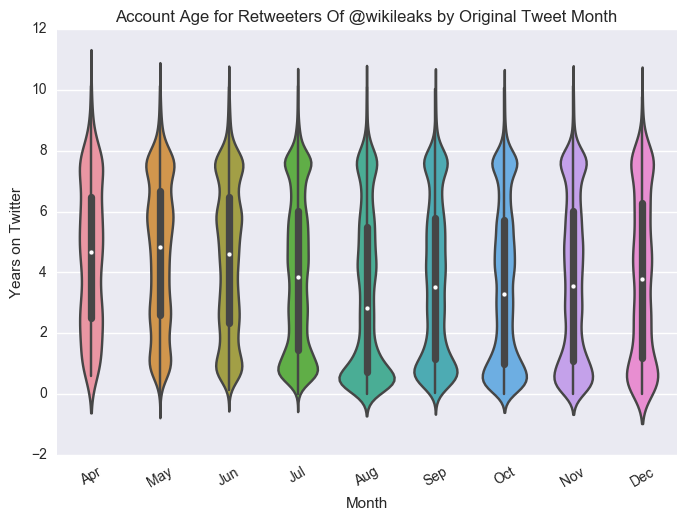

In [132]:
sns.violinplot(df.created_at.dt.month, df.age);
plt.title('Account Age for Retweeters Of @wikileaks by Original Tweet Month')
plt.ylabel('Years on Twitter')
plt.xlabel('Month')
plt.axes().set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug',
                    'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks(rotation=30);

In [ ]:
sns.

In [97]:
np.percentile(df['followers_to_friends'].dropna(), 95, )

4.7628865979381443

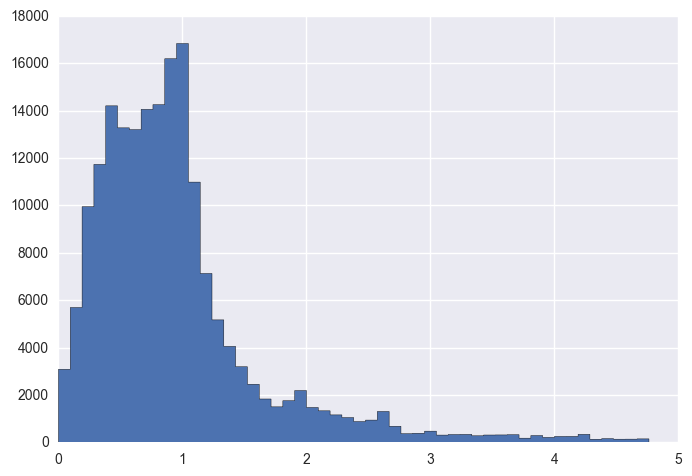

In [103]:
df[df['followers_to_friends'] < 4.7628865979381443]['followers_to_friends'].hist(bins=50, histtype='stepfilled')

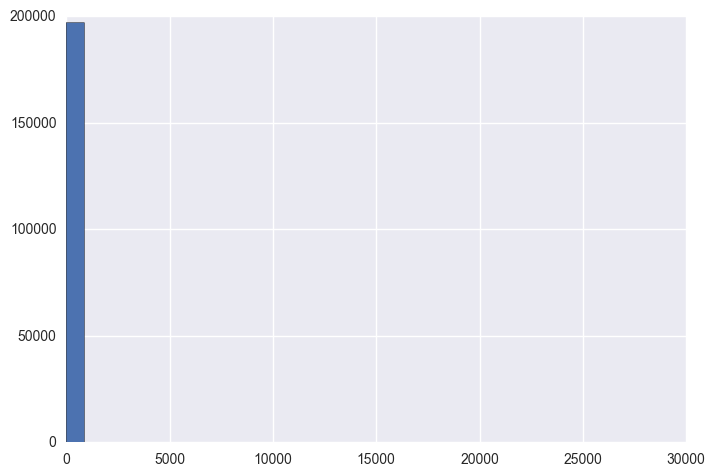

In [93]:
df['followers_to_friends'].hist(bins=30, histtype='stepfilled');

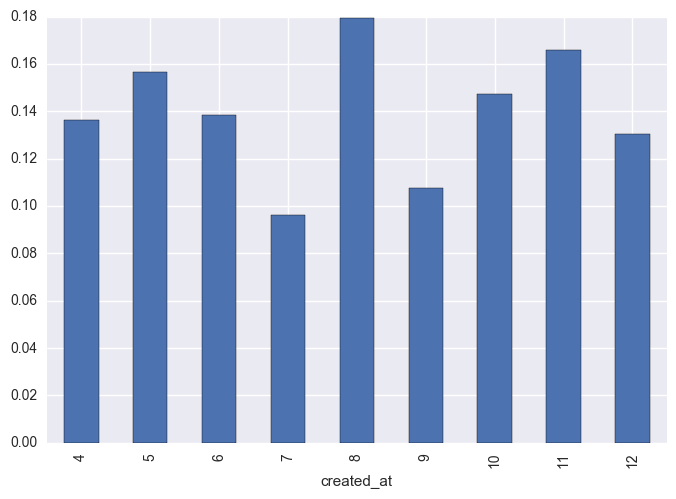

In [89]:
summary_df['few_followers'].plot(kind='bar');

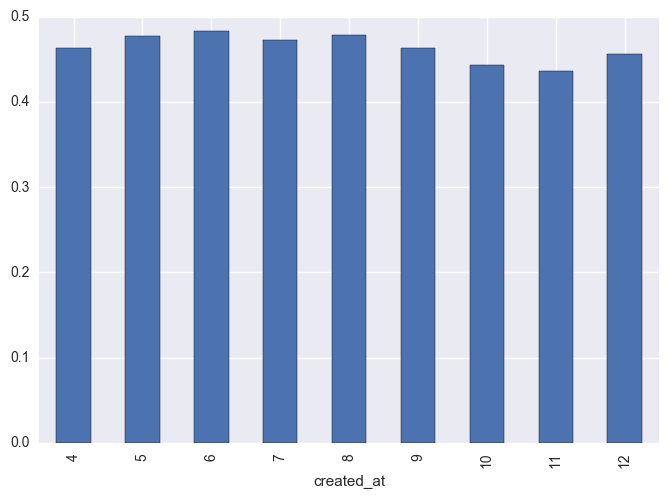

In [80]:
summary_df['followers_to_friends'].plot(kind='bar');

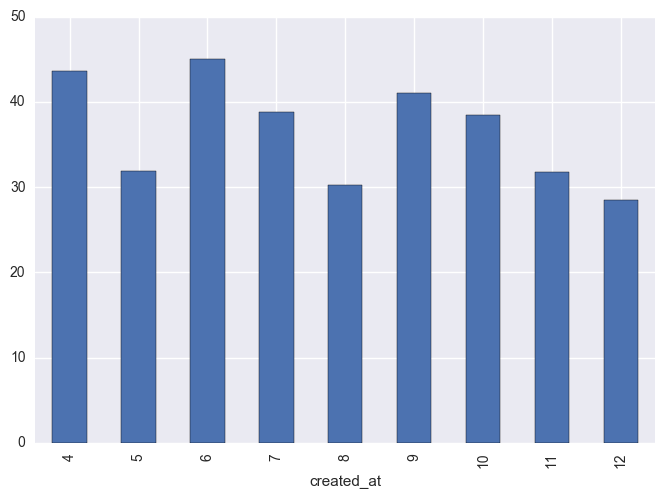

In [82]:
summary_df['faves_per_friends'].plot(kind='bar');

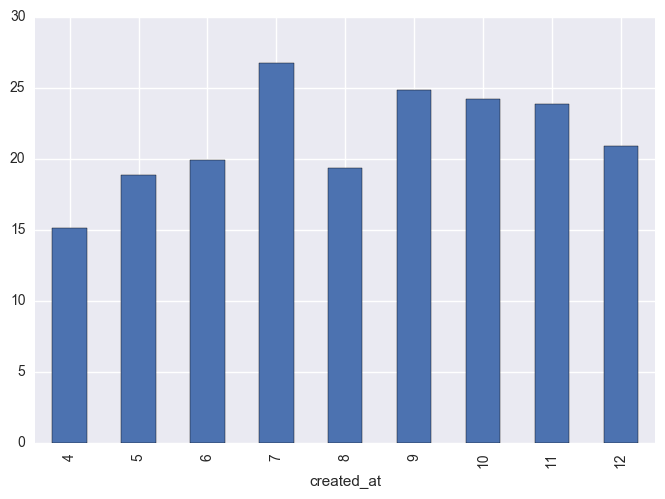

In [83]:
summary_df['faves_per_follower'].plot(kind='bar');